In [1]:
"""Topic: Exploring and visualizing NFL statistics in pandas)
Web scraping data from Pro-Football-Reference for analysis
"""

from bs4 import BeautifulSoup
import requests, re
import pandas as pd
import numpy as np

from stat_functions import all_position_stats, all_wide_receiver_quarterback_headers
from get_df import get_wide_receiver_df, all_individual_stats
from get_df_fantasy import fantasy_points


import matplotlib.pyplot as plt
%matplotlib inline

import patsy
import seaborn as sns

from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

import statsmodels.formula.api as smf
import statsmodels.api as sm

In [8]:
# df_all_wide_receivers_2019 = all_position_stats('2019','receiving', 29)
# df_all_wide_receivers_2019.columns = all_wide_receiver_quarterback_headers('2019','receiving')

# # Pickling
# df_all_wide_receivers_2019 = pd.read_pickle("./pickled/df_all_wide_receivers_2019.pkl")
# df_all_wide_receivers_2019[['Rec','Yds','Yds','Y/R','TD']] = df_all_wide_receivers_2019[['Rec','Yds','Yds','Y/R','TD']].apply(pd.to_numeric)
# df_all_wide_receivers_2019 = df_all_wide_receivers_2019.sort_values('Yds',ascending=False)
# df_all_wide_receivers_2019 = df_all_wide_receivers_2019[(df_all_wide_receivers_2019.Pos != 'RB') & (df_all_wide_receivers_2019.Pos != 'rb')] 
# df_all_wide_receivers_2019.to_pickle("./pickled/df_all_wide_receivers_2019.pkl")
df_all_wide_receivers_2019 = pd.read_pickle("./pickled/df_all_wide_receivers_2019.pkl")
df_all_wide_receivers_2019

,Link,Player,Tm,Age,Pos,G,GS,Tgt,Rec,Ctch%,Yds,Y/R,TD,1D,Lng,Y/Tgt,R/G,Y/G,Fmb
Michael Thomas,/players/T/ThomMi05.htm,Michael Thomas*+,NOR,26,WR,16,15,185,149,80.5%,1725,11.6,9,91,49,9.3,9.3,107.8,1
Julio Jones,/players/J/JoneJu02.htm,Julio Jones *,ATL,30,WR,15,15,157,99,63.1%,1394,14.1,6,77,54,8.9,6.6,92.9,1
Chris Godwin,/players/G/GodwCh00.htm,Chris Godwin*,TAM,23,WR,14,14,121,86,71.1%,1333,15.5,9,63,71,11.0,6.1,95.2,0
Travis Kelce,/players/K/KelcTr00.htm,Travis Kelce*,KAN,30,TE,16,16,136,97,71.3%,1229,12.7,5,65,47,9.0,6.1,76.8,1
Keenan Allen,/players/A/AlleKe00.htm,Keenan Allen*,LAC,27,WR,16,16,149,104,69.8%,1199,11.5,6,63,45,8.0,6.5,74.9,0
Amari Cooper,/players/C/CoopAm00.htm,Amari Cooper*,DAL,25,WR,16,16,119,79,66.4%,1189,15.1,8,54,53,10.0,4.9,74.3,0
D.J. Moore,/players/M/MoorD.00.htm,D.J. Moore,CAR,22,WR,15,15,135,87,64.4%,1175,13.5,4,63,52,8.7,5.8,78.3,2
Jarvis Landry,/players/L/LandJa00.htm,Jarvis Landry*,CLE,27,WR,16,16,138,83,60.1%,1174,14.1,6,55,65,8.5,5.2,73.4,0
DeAndre Hopkins,/players/H/HopkDe00.htm,DeAndre Hopkins*+,HOU,27,WR,15,15,150,104,69.3%,1165,11.2,7,68,43,7.8,6.9,77.7,0
Cooper Kupp,/players/K/KuppCo00.htm,Cooper Kupp,LAR,26,WR,16,14,134,94,70.1%,1161,12.4,10,51,66,8.7,5.9,72.6,3


In [9]:
# all_wide_receivers_2019 = all_individual_stats(get_wide_receiver_df, df_all_wide_receivers_2019, '2019')
# all_wide_receivers_2019.to_pickle("./pickled/all_wide_receivers_2019.pkl")

all_wide_receivers_2019 = pd.read_pickle("./pickled/all_wide_receivers_2019.pkl")
all_wide_receivers_2019

,index,Name,Date,Game,Week,Team,Opp,Result,Targets,Receptions,Total_Yards,Yards_per_Reception,Touchdowns,Catch%
0,0,Michael Thomas,2019-09-09,1,1,NOR,HOU,W 30-28,13,10,123,12.30,0,76.9%
1,1,Michael Thomas,2019-09-15,2,2,NOR,LAR,L 9-27,13,10,89,8.90,0,76.9%
2,2,Michael Thomas,2019-09-22,3,3,NOR,SEA,W 33-27,7,5,54,10.80,1,71.4%
3,3,Michael Thomas,2019-09-29,4,4,NOR,DAL,W 12-10,9,9,95,10.56,0,100.0%
4,4,Michael Thomas,2019-10-06,5,5,NOR,TAM,W 31-24,13,11,182,16.55,2,84.6%
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378,8,Austin Hooper,2019-11-10,9,10,ATL,NOR,W 26-9,5,4,17,4.25,1,80.0%
379,9,Austin Hooper,2019-12-08,13,14,ATL,CAR,W 40-20,6,2,32,16.00,0,33.3%
380,10,Austin Hooper,2019-12-15,14,15,ATL,SFO,W 29-22,6,3,20,6.67,0,50.0%
381,11,Austin Hooper,2019-12-22,15,16,ATL,JAX,W 24-12,9,7,82,11.71,0,77.8%


In [11]:
# all_wide_receivers_fantasy_2019 = all_individual_stats(fantasy_points, df_all_wide_receivers_2019, '2019')
# all_wide_receivers_fantasy_2019.to_pickle("./pickled/all_wide_receivers_fantasy_2019.pkl")

# all_wide_receivers_fantasy_2019 = pd.read_pickle("./pickled/all_wide_receivers_fantasy_2019.pkl")
all_wide_receivers_fantasy_2019

,index,Name,Fantasy_Points
0,0,Michael Thomas,12.3
1,1,Michael Thomas,8.9
2,2,Michael Thomas,11.4
3,3,Michael Thomas,9.5
4,4,Michael Thomas,30.2
...,...,...,...
378,8,Austin Hooper,7.7
379,9,Austin Hooper,3.2
380,10,Austin Hooper,2.0
381,11,Austin Hooper,8.2


In [35]:
# df_receiving_fantasy_2019 = all_wide_receivers_fantasy_2019.iloc[:,-1:]

# receptions_points = all_wide_receivers_2019.iloc[:,9:10]*0.5
# df_receiving_fantasy_2019['Total_Reception_Points'] = receptions_points['Receptions']

# receiving_yard_points = all_wide_receivers_2019.iloc[:,10:11]/10
# df_receiving_fantasy_2019['Total_Yards_Points'] = receiving_yard_points['Total_Yards']

# receiving_td_points = all_wide_receivers_2019.iloc[:,12:13]*6
# df_receiving_fantasy_2019['Total_TD_Points'] = receiving_td_points['Touchdowns']

# df_receiving_fantasy_2019 = df_receiving_fantasy_2019.dropna()

# df_receiving_fantasy_2019.to_pickle("./pickled/df_receiving_fantasy_2019.pkl")

df_receiving_fantasy_2019 = pd.read_pickle("./pickled/df_receiving_fantasy_2019.pkl")
df_receiving_fantasy_2019

,Fantasy_Points,Total_Reception_Points,Total_Yards_Points,Total_TD_Points
0,12.3,5.0,12.3,0
1,8.9,5.0,8.9,0
2,11.4,2.5,5.4,6
3,9.5,4.5,9.5,0
4,30.2,5.5,18.2,12
...,...,...,...,...
378,7.7,2.0,1.7,6
379,3.2,1.0,3.2,0
380,2.0,1.5,2.0,0
381,8.2,3.5,8.2,0


In [36]:
df_receiving_fantasy_2019.corr()

,Fantasy_Points,Total_Reception_Points,Total_Yards_Points,Total_TD_Points
Fantasy_Points,1.000000,0.644985,0.840387,0.811732
Total_Reception_Points,0.644985,1.000000,0.772432,0.293612
Total_Yards_Points,0.840387,0.772432,1.000000,0.385822
Total_TD_Points,0.811732,0.293612,0.385822,1.000000


&lt;AxesSubplot:&gt;

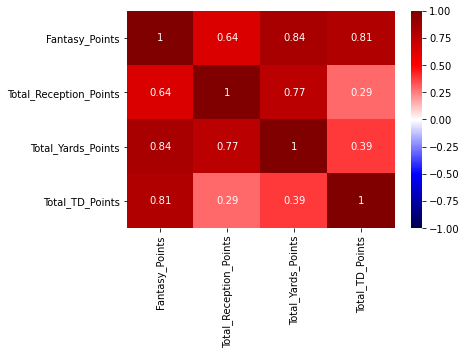

In [39]:
sns.heatmap(df_receiving_fantasy_2019.corr(), cmap='seismic', annot=True, vmin=-1, vmax=1)

&lt;seaborn.axisgrid.PairGrid at 0x149224fd0&gt;

&lt;Figure size 2160x1440 with 0 Axes&gt;

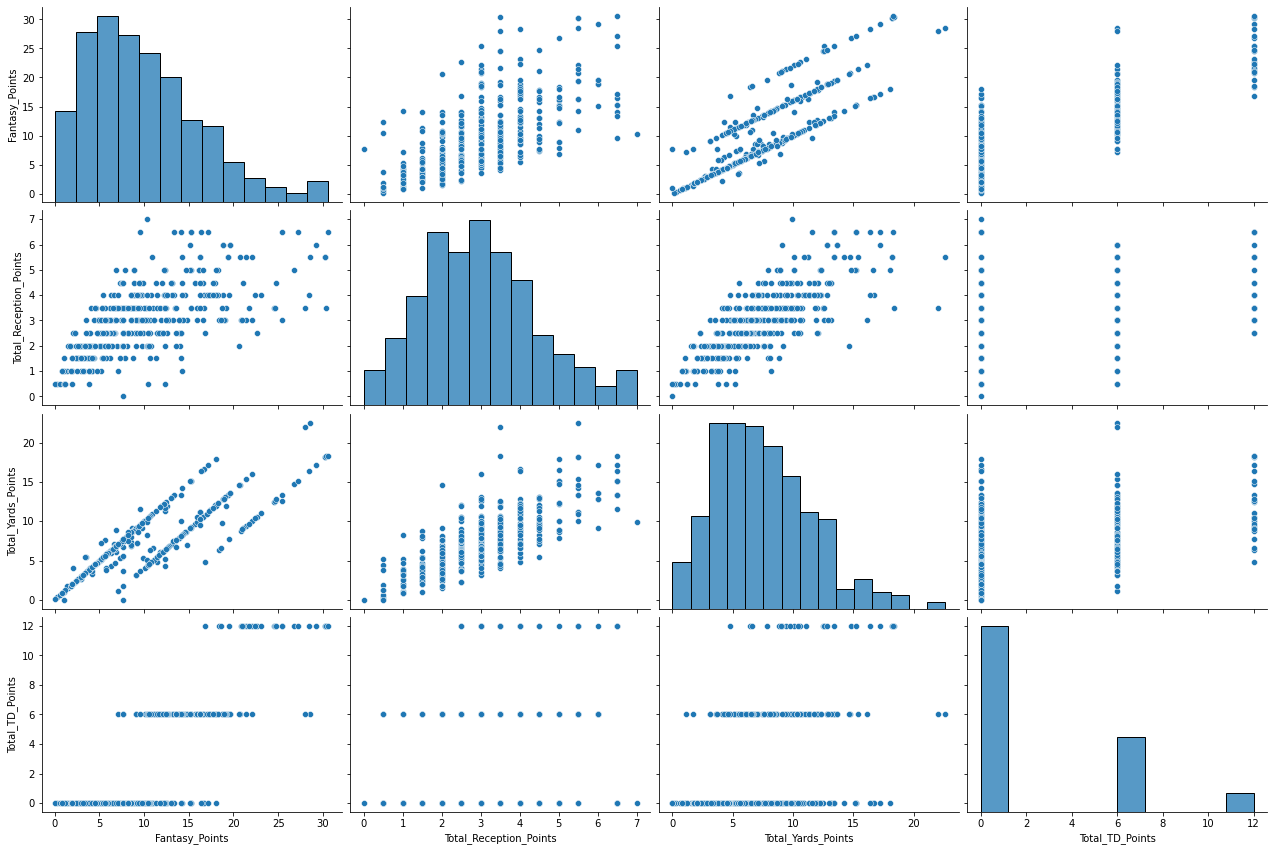

In [45]:
plt.figure(figsize = [30,20])

sns.pairplot(df_receiving_fantasy_2019, height=3, aspect=1.5)

In [46]:
# Create your feature matrix (X) and target vector (y)
y, X = patsy.dmatrices('Fantasy_Points ~ Total_Reception_Points + Total_Yards_Points + Total_TD_Points', data=df_receiving_fantasy_2019, return_type="dataframe")

# Create your model
model = sm.OLS(y, X)

# Fit your model to your training set
fit = model.fit()

# Print summary statistics of the model's performance
fit.summary()

&lt;class &#39;statsmodels.iolib.summary.Summary&#39;&gt;
&quot;&quot;&quot;
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Fantasy_Points   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                     8500.
Date:                Wed, 07 Oct 2020   Prob (F-statistic):               0.00
Time:                        01:20:00   Log-Likelihood:                -439.28
No. Observations:                 380   AIC:                             886.6
Df Residuals:                     376   BIC:                             902.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P&gt;|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0.2740      0.096      2.844      0.005       0.085       0.463
Total_Reception_Points    -0.0186      0.045     -0.413      0.680      -0.107       0.070
Total_Yards_Points         0.9902      0.016     61.378      0.000       0.958       1.022
Total_TD_Points            0.9903      0.012     84.993      0.000       0.967       1.013
==============================================================================
Omnibus:                      351.976   Durbin-Watson:                   2.019
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14394.379
Skew:                           3.738   Prob(JB):                         0.00
Kurtosis:                      32.210   Cond. No.                         24.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
&quot;&quot;&quot;

In [48]:
# Define the model
lm1 = smf.ols('Fantasy_Points ~ Total_Yards_Points + Total_TD_Points', data=df_receiving_fantasy_2019)

# Fit the model
fit1 = lm1.fit()

# Print summary statistics of the model's performance
fit1.summary()

&lt;class &#39;statsmodels.iolib.summary.Summary&#39;&gt;
&quot;&quot;&quot;
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Fantasy_Points   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                 1.278e+04
Date:                Wed, 07 Oct 2020   Prob (F-statistic):               0.00
Time:                        01:20:42   Log-Likelihood:                -439.37
No. Observations:                 380   AIC:                             884.7
Df Residuals:                     377   BIC:                             896.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P&gt;|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.2547      0.084      3.026      0.003       0.089       0.420
Total_Yards_Points     0.9852      0.011     92.023      0.000       0.964       1.006
Total_TD_Points        0.9904      0.012     85.092      0.000       0.967       1.013
==============================================================================
Omnibus:                      352.379   Durbin-Watson:                   2.019
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14562.660
Skew:                           3.741   Prob(JB):                         0.00
Kurtosis:                      32.390   Cond. No.                         19.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
&quot;&quot;&quot;

&lt;AxesSubplot:&gt;

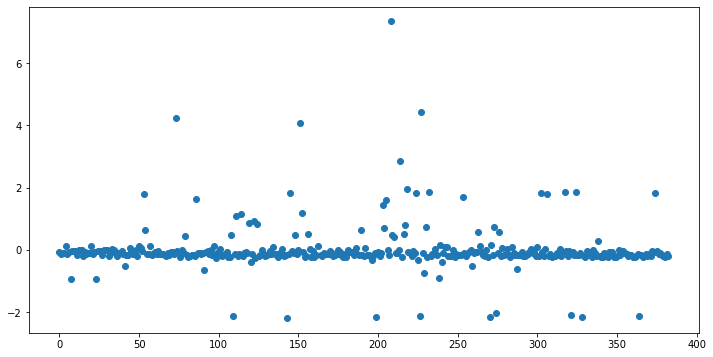

In [49]:
#Residual plot comparing actual vs. predicted values. In a good model we want our errors to be random. I'm not sure if the below looks too random. It seems to be between 0, so what does that mean? May be missing actual functional dependency underlying the data. This data may not be linear but let's keep going. 
fit1.resid.plot(style='o',figsize=(12,6))